In [46]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.interpolate import griddata

In [47]:
cube_lengths = [0.025, 0.03, 0.035, 0.04, 0.045]
cubie_ratios = [0.005, 0.01, 0.015]

In [48]:
results = []
folder = 'cube_length_cubie_ratio_results'
for json_file in os.listdir(folder):
    _, cube_length_idx, _, cubie_ratio_idx, rotation = json_file.split('.')[0].split('_')
    json_file = os.path.join(folder,json_file)
    with open(json_file, "r") as file:
        data = json.load(file)
    angular_error = sum(data.values()) / len(data.values())
    results.append([cube_lengths[int(cube_length_idx)], cubie_ratios[int(cubie_ratio_idx)], rotation, angular_error])
results

[[0.03, 0.005, "U'", 0.017346911627007366],
 [0.04, 0.005, "F'", 0.012587887864479199],
 [0.045, 0.01, "U'", 0.1559804634968246],
 [0.035, 0.01, 'U', 0.004356365684835063],
 [0.035, 0.005, "R'", 0.021135831952444516],
 [0.04, 0.015, 'U', 0.02696987805588276],
 [0.025, 0.01, 'F', 0.020201532249168968],
 [0.03, 0.015, "R'", 0.04648740204316565],
 [0.03, 0.015, 'F', 0.03746314864976732],
 [0.035, 0.015, "U'", 0.8372817467519722],
 [0.025, 0.015, "F'", 0.0850149482314184],
 [0.045, 0.005, 'F', 0.012765805479860372],
 [0.03, 0.005, 'R', 0.03212556718094864],
 [0.045, 0.015, 'R', 1.4961460442555103],
 [0.025, 0.01, 'R', 0.030105289503514213],
 [0.045, 0.015, "R'", 1.008999205181787],
 [0.045, 0.005, 'R', 1.790181568657292],
 [0.03, 0.015, 'R', 0.04076579238594274],
 [0.045, 0.015, 'F', 0.05779968184939358],
 [0.03, 0.005, 'F', 0.020452488908203774],
 [0.04, 0.01, "F'", 0.019902622454651523],
 [0.03, 0.01, "U'", 0.011572645183547618],
 [0.045, 0.005, "U'", 0.1344293418185477],
 [0.04, 0.005, 

In [49]:
sorted(results, key = lambda x : x[3])

[[0.035, 0.01, 'U', 0.004356365684835063],
 [0.04, 0.005, 'U', 0.00514781524363046],
 [0.03, 0.01, 'U', 0.0053163712071359484],
 [0.035, 0.015, 'U', 0.00650742895765318],
 [0.035, 0.005, 'U', 0.0067370934314049825],
 [0.025, 0.01, 'U', 0.0070586859095849155],
 [0.045, 0.01, 'F', 0.00871034507344208],
 [0.04, 0.005, "U'", 0.00902097330859636],
 [0.025, 0.005, "U'", 0.009150627595462306],
 [0.03, 0.015, 'U', 0.009303185927287653],
 [0.025, 0.015, 'U', 0.010661930937079756],
 [0.035, 0.01, "U'", 0.011554107879128115],
 [0.03, 0.01, "U'", 0.011572645183547618],
 [0.025, 0.015, 'F', 0.01200993524722059],
 [0.04, 0.005, "F'", 0.012587887864479199],
 [0.035, 0.005, "F'", 0.012724914846074367],
 [0.045, 0.005, 'F', 0.012765805479860372],
 [0.025, 0.005, 'U', 0.013742566724220934],
 [0.045, 0.005, "F'", 0.014171162557579421],
 [0.025, 0.005, "F'", 0.01510634920216193],
 [0.035, 0.005, "U'", 0.01519894198353014],
 [0.03, 0.005, "F'", 0.015280860483142226],
 [0.035, 0.01, "F'", 0.0154662508034199

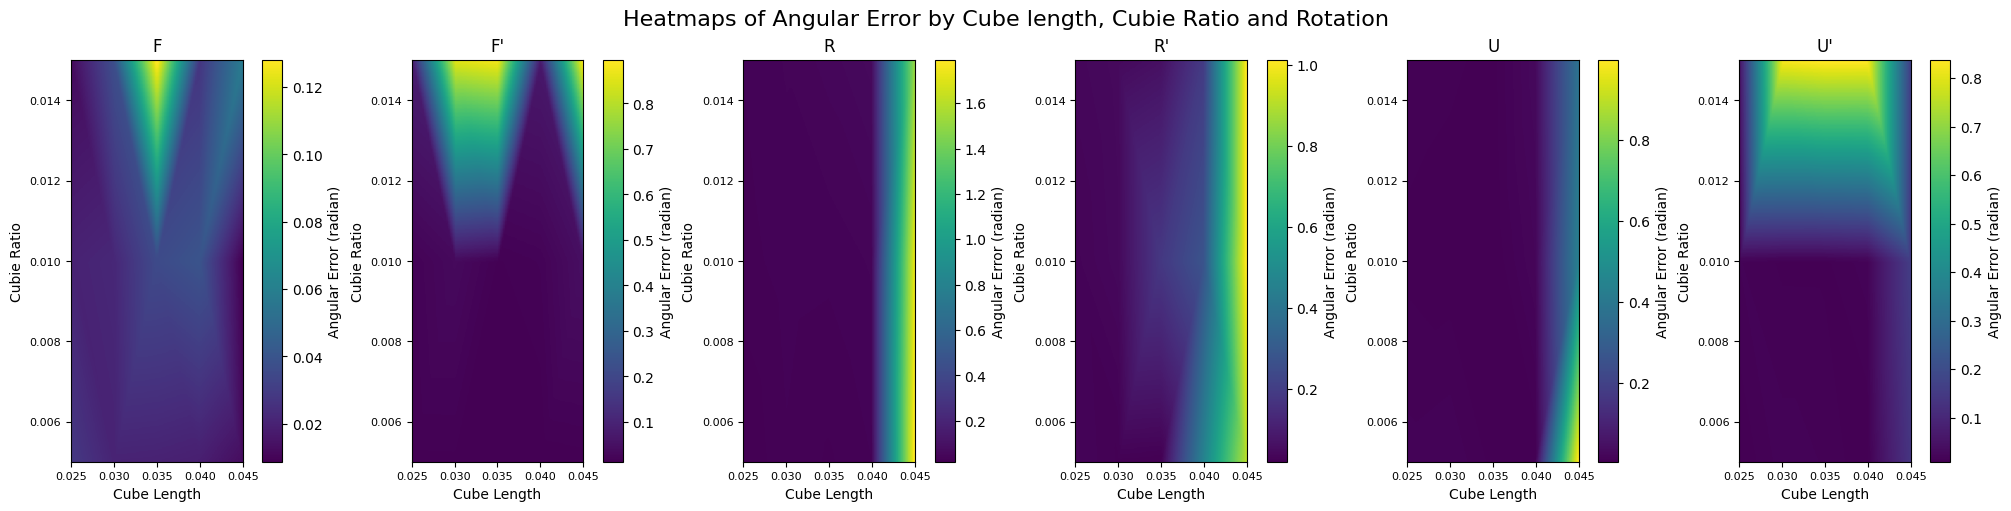

In [50]:
# Data (Replace `results` with your actual data)
data = results

# Extract components
cube_length = np.array([entry[0] for entry in data])
cubie_ratio = np.array([entry[1] for entry in data])
rotations = np.array([entry[2] for entry in data])
error = np.array([entry[3] for entry in data])

# Unique rotations
unique_rotations = np.unique(rotations)

# Set up the grid for heatmaps
cube_length_grid = np.linspace(min(cube_length), max(cube_length), 100)
cubie_ratio_grid = np.linspace(min(cubie_ratio), max(cubie_ratio), 100)
grid_x, grid_y = np.meshgrid(cube_length_grid, cubie_ratio_grid)

# Create heatmaps for each rotation
fig, axes = plt.subplots(1, len(unique_rotations), figsize=(20, 5), constrained_layout=True)
for i, rotation in enumerate(unique_rotations):
    # Mask data for the current rotation
    mask = rotations == rotation
    grid_z = griddata(
        (cube_length[mask], cubie_ratio[mask]), error[mask],
        (grid_x, grid_y), method='linear'
    )

    # Plot heatmap
    ax = axes[i]
    heatmap = ax.imshow(
        grid_z,
        extent=[
            min(cube_length), max(cube_length),
            min(cubie_ratio), max(cubie_ratio)
        ],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )

    # Titles and labels
    ax.set_title(f'{rotation}', fontsize=12)
    ax.set_xlabel('Cube Length', fontsize=10)
    ax.set_ylabel('Cubie Ratio', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

    # Add color bar
    cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Angular Error (radian)', fontsize=10)

# Overall plot title
fig.suptitle('Heatmaps of Angular Error by Cube length, Cubie Ratio and Rotation', fontsize=16)
# plt.savefig('error_heatmaps.png', dpi=300)
plt.show()


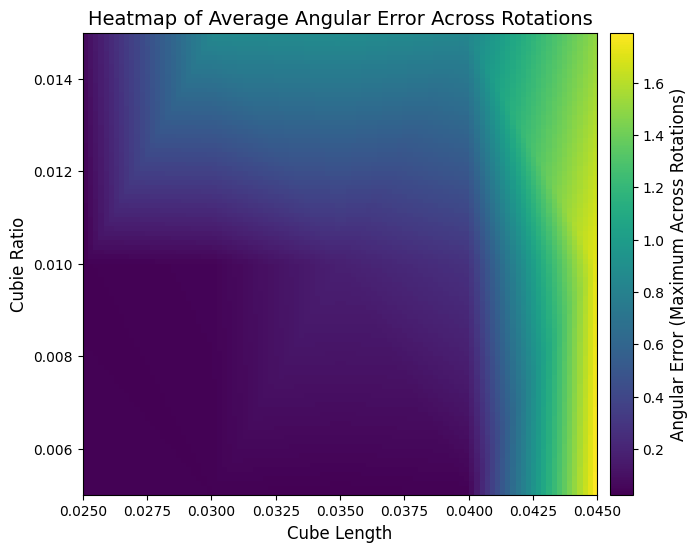

In [57]:
# Data (Replace `results` with your actual data)
data = results

# Extract components
cube_length = np.array([entry[0] for entry in data])
cubie_ratio = np.array([entry[1] for entry in data])
rotations = np.array([entry[2] for entry in data])
error = np.array([entry[3] for entry in data])

# Aggregate maximum error for each (friction, spacing)
# Group errors by unique (friction, spacing) pairs
unique_pairs = list(set(zip(cube_length, cubie_ratio)))
max_error_per_pair = {
    pair: max(error[(cube_length == pair[0]) & (cubie_ratio == pair[1])])
    for pair in unique_pairs
}

# Prepare data for interpolation
cube_length_unique = np.array([pair[0] for pair in unique_pairs])
cubie_ratio_unique = np.array([pair[1] for pair in unique_pairs])
error_max = np.array([max_error_per_pair[pair] for pair in unique_pairs])

# Set up the grid for heatmap
cube_length_grid = np.linspace(min(cube_length), max(cube_length), 100)
cubie_ratio_grid = np.linspace(min(cubie_ratio), max(cubie_ratio), 100)
grid_x, grid_y = np.meshgrid(cube_length_grid, cubie_ratio_grid)

# Interpolate the maximum error for the grid
grid_z = griddata(
    (cube_length_unique, cubie_ratio_unique), error_max,
    (grid_x, grid_y), method='linear'
)

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.imshow(
    grid_z,
    extent=[
        min(cube_length), max(cube_length),
        min(cubie_ratio), max(cubie_ratio)
    ],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

# Add title and axis labels
ax.set_title('Heatmap of Average Angular Error Across Rotations', fontsize=14)
ax.set_xlabel('Cube Length', fontsize=12)
ax.set_ylabel('Cubie Ratio', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Angular Error (Maximum Across Rotations)', fontsize=12)

# Save the figure
# plt.savefig('maximum_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
def avg(x) : return sum(x) / len(x)

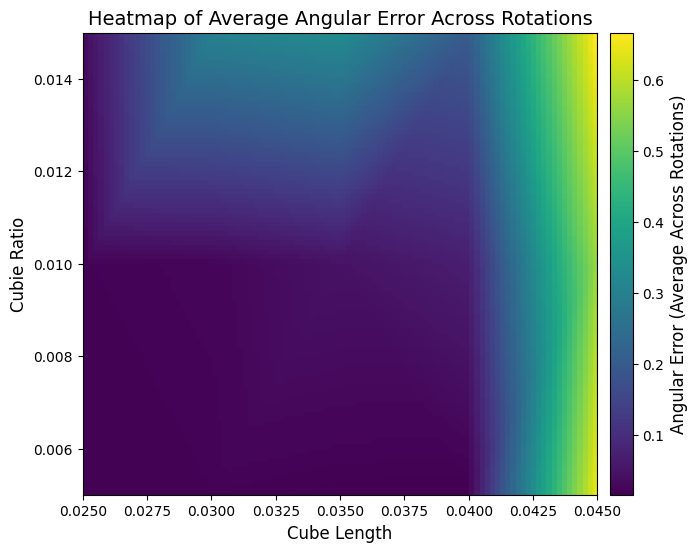

In [59]:
# Data (Replace `results` with your actual data)
data = results

# Extract components
cube_length = np.array([entry[0] for entry in data])
cubie_ratio = np.array([entry[1] for entry in data])
rotations = np.array([entry[2] for entry in data])
error = np.array([entry[3] for entry in data])

# Aggregate maximum error for each (friction, spacing)
# Group errors by unique (friction, spacing) pairs
unique_pairs = list(set(zip(cube_length, cubie_ratio)))
max_error_per_pair = {
    pair: avg(error[(cube_length == pair[0]) & (cubie_ratio == pair[1])])
    for pair in unique_pairs
}

# Prepare data for interpolation
cube_length_unique = np.array([pair[0] for pair in unique_pairs])
cubie_ratio_unique = np.array([pair[1] for pair in unique_pairs])
error_max = np.array([max_error_per_pair[pair] for pair in unique_pairs])

# Set up the grid for heatmap
cube_length_grid = np.linspace(min(cube_length), max(cube_length), 100)
cubie_ratio_grid = np.linspace(min(cubie_ratio), max(cubie_ratio), 100)
grid_x, grid_y = np.meshgrid(cube_length_grid, cubie_ratio_grid)

# Interpolate the maximum error for the grid
grid_z = griddata(
    (cube_length_unique, cubie_ratio_unique), error_max,
    (grid_x, grid_y), method='linear'
)

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.imshow(
    grid_z,
    extent=[
        min(cube_length), max(cube_length),
        min(cubie_ratio), max(cubie_ratio)
    ],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

# Add title and axis labels
ax.set_title('Heatmap of Average Angular Error Across Rotations', fontsize=14)
ax.set_xlabel('Cube Length', fontsize=12)
ax.set_ylabel('Cubie Ratio', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Angular Error (Average Across Rotations)', fontsize=12)

# Save the figure
# plt.savefig('maximum_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()